In [117]:
# 必要なライブラリ全部import
import numpy as np
import matplotlib.pyplot as plt
import csv
import math

import random
import scipy as scp
import pandas as pd


In [118]:
# ２値データのCSV化
def data_to_csv(x_list, y_list, name="data", encoding="cp932"):
    if len(x_list) != len(y_list):
        return -1
    else:
        values = np.array([x_list, y_list]).T
        num_list = range(1, len(x_list)+1)
        column_list = ["x", "y"]
        result_pd = pd.DataFrame(data=values, index=num_list, columns=column_list)
        result_pd.to_csv(name+".csv", encoding='cp932')

# csv読み込んでfloat加工してnd_array型にする
def open_csv_to_float(file_path):
    with open(file_path, 'r') as f:
        data = csv.reader(f)
        data = list(data)
    return np.array(data).T.astype(float)

# 完成コード
# 最初のチェック
# チェックが済んだら，終了フラグと次元数とstepを返す
def initial_test(func_, dfunc_, init_z, step):
    # このフラグは異常を見つけたら1になる．
    flag_init = 0
    # 最初に導関数リストと初期値の次元のチェック
    # 合っていなければフラグを立てる
    if len(dfunc_) != len(init_z):
        print("[error] 関数と初期値の次元が異なる．")
        flag_init = 1
    # 合っている場合は次元数を定義
    else:
        dim = len(init_z)
    
    # 関数と導関数の初期値でOverflowを起こすならば初期値を変えるしかないのでフラグを立てる
    try:
        test_f = func_(init_z)
        test_df = [dfunc_[j](init_z) for j in range(dim)]
    except OverflowError:
        flag_init = 1
        print("Choose the other init_value")
    
    # step が負か1以上の数字なら，ステップを強制的に調整する．
    if (step <= 0. or step >= 1.):
        step = 0.1
    # 終了フラグ，次元数，ステップを返す
    return flag_init, dim, step

# z の更新に関する関数
def next_z(func_, dfunc_, step, z_now, dim, MAX_UPDATE=100):
    # MAX_UPDATEまでしても更新できなかったときは処理を終了させるためのフラグ
    # 終了条件の中にこのフラグを条件に組み込む
    # もう全く進まないとか，-infまで落ちるときの対策
    flag_z = 0
    # 勾配ベクトルを内部関数として定義する
    def grad(dfunc_, z, dim):
            return np.array([dfunc_[j](z) for j in range(dim)])
    for k in range(MAX_UPDATE):
        # 先に勾配が計算出来ることを確認しているのでここで+infの方に超えることはない．(おそらく...)
        z_update = z_now - step * grad(dfunc_, z_now, dim)
    # Overflowが起こったらstepを減少させる
        try:
            flag = bool(func_(z_now) > func_(z_update))
        except OverflowError:
            step *= 0.5
            continue
        # flagが立てば正常終了
        if flag:
            return z_update, step, flag_z
        # step幅を減少させて再び更新を試す．
        else:
            # print("reduced step")
            step *= 0.5
    # 上限更新を経てしまったときは，フラグを立てて終了条件に引っかける
    if k == (MAX_UPDATE - 1):
        flag_z = 1
        # ｚの更新値，更新されたステップ，終了フラグを返す
        return z_update, step, flag_z

# func_: 最小値を求めたい対象の関数
# 任意の次元の関数で実行可能
def multi_grad_descent(func_, dfunc_: list, init_z: list, accuracy=10e-4, step=0.01, MAX_LOOP=1000, debug=True):
    # 最初のチェックを回す
    flag_end, dim_now, step = initial_test(func_, dfunc_, init_z, step)
    # フラグが立っていたら終了する．データはNoneで返す
    if flag_end:
        return [None for s in range(dim_now)]
    # 勾配ベクトルを内部関数として定義する
    def grad(dfunc_, z, dim=dim_now):
            return np.array([dfunc_[j](z) for j in range(dim)])
    z_old = np.array(init_z)
    # 勾配ベクトルの２乗ノルムを記録する．勾配->0になる挙動を観察するため
    acc_list = [np.linalg.norm(grad(dfunc_, z_old))]
    for i in range(MAX_LOOP):
        # zを更新する
        z_new, step, flag_z = next_z(func_, dfunc_, step, z_now=z_old, dim=dim_now, MAX_UPDATE=100)
        # 2乗ノルムを判定値にする
        judge = np.linalg.norm(grad(dfunc_, z_new, dim=dim_now))
        acc_list.append(judge)
        # 終了判定は上限回数回してもｚの更新ができないときのフラグが立った時か
        # 勾配ベクトルの2乗ノルムが十分小さいとき
        if (judge < accuracy or flag_z):
            if flag_z:
                print("z の更新が最大に達したので強制終了．今の値を返します")
            break
        else:
            z_old = z_new
    print("[{}]: z= {}, min f(z)= {}".format(i+1, z_new, func_(z_new)))
    if debug:
        plt.plot(range(len(acc_list)), acc_list)
        plt.show()
    return z_new, func_(z_new), acc_list


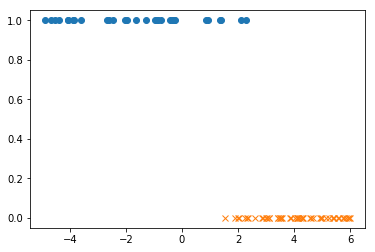

In [119]:
data01 = open_csv_to_float("./Logistic_data01.csv")
# 予想値：W = [3.6, -5.2, -8]
data01_T = data01.T
# print(data01)
data01_ones = np.array([list(data01_T[i]) for i in range(len(data01_T)) if data01_T[i][1] == 1.]).T
data01_zeros = np.array([list(data01_T[i]) for i in range(len(data01_T)) if data01_T[i][1] == 0.]).T

plt.plot(data01_ones[0], data01_ones[1], "o")
plt.plot(data01_zeros[0], data01_zeros[1], "x")


In [58]:
def sigmoid(x):
    return 1./(1.+np.e**(-x))

def loss_diff(w, data_x, data_y, C=0.0):
    w = np.array(w)
    return np.dot(data_x, sigmoid(np.dot(data_x.T, w) ) - data_y) + C*w

# i番目の勾配値を取得する
def loss_igrad(w, i, data_x, data_y, C=0.0):
    def loss_diff(w, data_x, data_y, C):
        w = np.array(w)
        return np.dot(data_x, sigmoid(np.dot(data_x.T, w) ) - data_y) + C*w
    grad = loss_diff(w, data_x, data_y, C)
    return grad[i]


def logistic_loss(w, data_x, data_y, C=0.0):
    w = np.array(w)
    return -np.dot( np.dot(data_x.T, w).T, data_y) \
            + np.sum(np.log( 1. + np.e**(np.dot(data_x.T, w)))) \
            + 0.5*C*(np.linalg.norm(w))**2



In [122]:
# データの作成
sample_x = np.array([data01_T[i][0] for i in range(len(data01_T))])
sample_y = np.array([data01_T[i][1] for i in range(len(data01_T))])
# Linear Logistic
# X = np.array([[1,s] for s in sample_x]).T
# X = np.array([[1,s,s**2] for s in sample_x]).T
# print(X)
# dim = len([w0,w1,..,wn]): dim=2: Linear
def make_polynomial_X(data_x, dim=2):
    X = []
    for j in range(len(data_x)):
        temp = []
        for k in range(dim):
            temp.append((data_x[j])**(k))
        X.append(temp)
    return np.array(X).T
X = make_polynomial_X(data_x= sample_x, dim=2)

In [134]:
# とりあえずtemp_fが計算できるものを初期値にしておく
temp_w = [1.0,1.0]
# temp_w = [1.0, 1.0, 1.0]
# 初期値の設定
dim = len(temp_w)
search_count=100
w_range = (-10, 10)
L2_c = 0.2

# 探索準備
temp_f = data02_Loss(temp_w)
loss_grad = [lambda w: loss_igrad(w, i=j, data_x=X, data_y=sample_y, C=L2_c) for j in range(dim)]
data02_Loss = lambda w: logistic_loss(w, data_x=X, data_y=sample_y, C=L2_c)
# 探索開始
for i in range(search_count):
    init_w = np.random.uniform(w_range[0], w_range[1],dim)
    w_new = multi_grad_descent(func_=data02_Loss, dfunc_=loss_grad, init_z=init_w, accuracy=10e-4, step=0.1, MAX_LOOP=1000, debug=False)
    if temp_f > w_new[1]:
        temp_f = w_new[1]
        temp_w = w_new[0]
# 結果をplotする
print("[{}]回でw*= {}, f(w*) = {}".format(search_count, temp_w, temp_f))


z の更新が最大に達したので強制終了．今の値を返します
[35]: z= [-1.32820737 -1.12626927], min f(z)= 30.356215005988762
z の更新が最大に達したので強制終了．今の値を返します
[7]: z= [ 4.31760704 -2.62414589], min f(z)= 9.70494733412993
[112]: z= [-28.15033726 -12.75245215], min f(z)= 567.3997041909254
z の更新が最大に達したので強制終了．今の値を返します
[13]: z= [ 0.73935991 -1.05236657], min f(z)= 12.81068373258584
[7]: z= [ 3.00251352 -1.99495395], min f(z)= 9.144652346096086
[83]: z= [-19.4644312   -9.16108829], min f(z)= 372.17042280024305
[15]: z= [-1.93047967 -1.31497785], min f(z)= 38.75084008997256
[92]: z= [-23.56329483 -10.9111897 ], min f(z)= 462.024471947321
[86]: z= [-4.84562077 -2.59306013], min f(z)= 86.3828447916282
z の更新が最大に達したので強制終了．今の値を返します
[13]: z= [ 6.83036317 -3.88691073], min f(z)= 13.1786834676182
z の更新が最大に達したので強制終了．今の値を返します
[5]: z= [ 5.73000506 -3.33497683], min f(z)= 11.346267211677834
[75]: z= [-18.81201207  -8.87734407], min f(z)= 358.24712363169994
z の更新が最大に達したので強制終了．今の値を返します
[20]: z= [ 5.65462218 -3.27320406], min f(z)= 11.216865057

[100]回でw*= [ 3.07526046 -2.02644105], f(w*) = 9.143948632245037


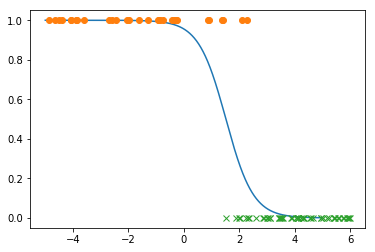

In [135]:
# 結果の表示
print("[{}]回でw*= {}, f(w*) = {}".format(search_count, temp_w, temp_f))

plot_testx = np.linspace(-5.,5., 1000)
# ここだけまだ次元の対応できてない
if len(temp_w) == 2:
    plot_testy = [sigmoid(temp_w[0]+ temp_w[1]*i) for i in plot_testx]
elif len(temp_w) == 3:
    plot_testy = [sigmoid(temp_w[0]+ temp_w[1]*i + temp_w[2]*(i)**2) for i in plot_testx]
plt.plot(plot_testx, plot_testy)
plt.plot(data01_ones[0], data01_ones[1], "o")
plt.plot(data01_zeros[0], data01_zeros[1], "x")


<img src="./data02_C0.png">
<img src="./data02_C1.png">
<img src="./data01_C0.png">
<img src="./data01_C02.png">

In [157]:
data01_c0_w = [ 5.87497504, -3.36925775]
data01_c02_w = [ 3.07526046, -2.02644105]
data01_c1_sk = [3.01337918, -1.90024688]
c0_w = [ 3.87559334, -8.84982156, -11.2037395]
c1_w = [ 1.78876831, -2.53053623, -3.09611265]

test02 = open_csv_to_float("./Logistic_test01.csv")
test02_x = test02[0]
test02_y = test02[1]
def judge_Logit(w, data_x, data_y):
    def sigmoid(x):
        return 1./(1.+np.e**(-x))
    def threshold(x, theta):
        if x >= theta:
            return 1
        else:
            return 0
    # (data_x.T)@wを作成
    w = np.array(w)
    w_dim = len(w)
    sample_num = len(data_y)
    X = []
    for j in range(sample_num):
        temp = []
        for k in range(w_dim):
            temp.append(w[k]*(data_x[j])**(k))
        X.append(sum(temp))
    X = np.array(X)
    pred_list = np.array([threshold(s, theta=0.5) for s in sigmoid(X)])
    accuracy = 1. - sum(abs(pred_list - data_y))/sample_num
    return accuracy


In [156]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression( random_state=42, solver='newton-cg')
result = lr.fit(np.array(data01[0]).reshape(-1, 1), data01[1])
print(lr.coef_, lr.intercept_) # [3.01337918, -1.90024688]

[[-1.90024688]] [3.01337918]


In [158]:
# data01
print("[data01] c=0: accuracy: {}".format(judge_Logit(data01_c0_w, test02_x, test02_y)))
print("[data01] c=0.2: accuracy: {}".format(judge_Logit(data01_c02_w, test02_x, test02_y)))
print("[data01] sk-newton-cg,default accuracy: {}".format(judge_Logit(data01_c1_sk, test02_x, test02_y)))

[data01] c=0: accuracy: 0.96
[data01] c=0.2: accuracy: 0.92
[data01] sk-newton-cg,default accuracy: 0.94


In [144]:
# data02
print("[data02] c=0: accuracy: {}".format(judge_Logit(c0_w, test02_x, test02_y)))
print("[data02] c=1: accuracy: {}".format(judge_Logit(c1_w, test02_x, test02_y)))

[data02] c=0: accuracy: 0.98
[data02] c=1: accuracy: 0.95


In [217]:
# 次の展望：Xが多次元線形の場合（多次元非線形はもういいや）
# データ作成
# x_zeros = 100
# x_ones = 100
# zeros_x_list = np.sort(np.random.multivariate_normal((2.,3.), ((2.,0.),(0, 2.)), x_zeros)).tolist()
# # print(zeros_x_list)
# ones_x_list = np.sort(np.random.multivariate_normal((-1.,1.), ((2.,-1.),(-1., 2.)), x_ones)).tolist()
# # print(ones_x_list)
# zeros_y_list = [0 for i in range(x_zeros)]
# ones_y_list = [1 for i in range(x_ones)]
# x_list = np.array(zeros_x_list + ones_x_list).T
# y_list = np.array(zeros_y_list + ones_y_list)
# def data_to_csv3(x0_list, x1_list, y_list, name="data", encoding="cp932"):
#     values = np.array([x0_list, x1_list, y_list]).T
#     num_list = range(1, len(y_list)+1)
#     column_list = ["x0", "x1", "y"]
#     result_pd = pd.DataFrame(data=values, index=num_list, columns=column_list)
#     result_pd.to_csv(name+".csv", encoding='cp932')

# data_to_csv3(x_list[0], x_list[1], y_list, name="Logistic_test03", encoding="cp932")


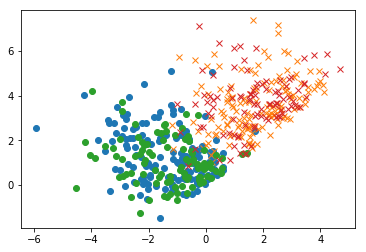

In [219]:
# 明日これ境界線を引く．

data03 = open_csv_to_float("./Logistic_data03.csv")
data03_T = data03.T
data03_ones = np.array([[data03_T[i][0],data03_T[i][1]] for i in range(len(data03_T)) if data03_T[i][2] == 1.]).T
data03_zeros = np.array([[data03_T[i][0],data03_T[i][1]]for i in range(len(data03_T)) if data03_T[i][2] == 0.]).T
plt.plot(data03_ones[0], data03_ones[1], "o")
plt.plot(data03_zeros[0], data03_zeros[1], "x")

data03 = open_csv_to_float("./Logistic_test03.csv")
data03_T = data03.T
data03_ones = np.array([[data03_T[i][0],data03_T[i][1]] for i in range(len(data03_T)) if data03_T[i][2] == 1.]).T
data03_zeros = np.array([[data03_T[i][0],data03_T[i][1]]for i in range(len(data03_T)) if data03_T[i][2] == 0.]).T
plt.plot(data03_ones[0], data03_ones[1], "o")
plt.plot(data03_zeros[0], data03_zeros[1], "x")

In [ ]:
1. data01に対して，最尤推定を用いてLogit曲線を生成せよ．
2. test01に対して，上のLogitを用いて分類精度を評価せよ．
3. data01に対して，C=0.2のL2正則化項を加えてLogit曲線を生成せよ．
    i.e. 尤度関数に，(C/2)*(||w||)^2 を加えて argmax for w をすることである．
-- advance issue 1 --
4. data02に対して，分類精度の出せるLogit曲線を生成せよ．
5. test02に対して，上のLogitを用いて分類精度を評価せよ．(私が生成したものは96%の正解率でした．)
-- advance issue 2 --
<data03 は，data01に対して，入力変数が２個になりました．>
6. data03に対して，分類精度の出せるLogit曲線を生成せよ．
7. test03に対して，上のLogitを用いて分類精度を評価せよ．(私が生成したものは96%の正解率でした．)